In [5]:
# The code was removed by Watson Studio for sharing.

   # Applied Data Science Capstone

## *!The Battle of Neighborhoods!*

---
### 1. Introduction/Business Problem

**In Costa Rica there is a company that sells tours to places of New York and Toronto, this company wants to offer its customers the possibility of visualizing the similarities and differences between one city and another in order to make a decision based on their travel preferences.**

**So in this project is aimed at tour operators interested in attracting more customers who wish to travel to the cities they offer, with the option to see the functionality between two of the major cities of note america such as Toronto and New York in our case.**

#### 1.1 Stackeholders

1. The project should interest companies that sell tours to different places and can easily recommend cities according to the similarity found with the help of the use of machine learning.

2. People who want to travel and have doubts about the destination to choose because they do not have enough information about destinations to make a decision.

---
### 2. Description of the data to be used to solve the problem

**For this project we will use the knowledge acquired in course 9 to use the benefits of the Forsquare API to explore data from both cities and neighborhoods, and data that is relevant for people who travel such as coffee shops, hotels, restaurants that can visit and be close, theaters and many places for which to have a choice.**


**We will also use the data that wikipedia provides about each neighborhood of both cities which can be accessed from: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M.

**Data from the neighborhoods of New York City will be charged from https://cocl.us/new_york_dataset.**

**Both datasets must be joined with data where the geospatial coordinates are available in order to consult and explore the necessary data with the Forsquare API. These data will be loaded from the address http://cocl.us/Geospatial_data with the help of the python requests module**

It must be prepared and cleaned to apply the algorithms that we will need:

1. First of all we will be working with all Boroughs that are necessary and provide value.
2. To be able to use the wikipedia data, the first thing is to extract the table with the Borough information and convert it into a dataframe so that we can work with the data as we need it. We will do this with the help of the BeautifulSoup python module
3. We will also eliminate all rows that have the value of "Not assigned" since they do not generate value.
4. In the case of neighborhoods that have the value of "Not assigned" they will be assigned the same value as the "Borough" data.
5. The similutud and differences will be based on the Boroughs, therefore we will group the Borough data and concatenate the values for each neighborhood.
6. To be able to perform explorations with the Forsquare API we will need to cross the data with the coordinates dataset. The merge of the data will be done through the Postcode column.
7. With the clean data for both New York and Toronto we can continue with the analysis of the data, the visualization to verify the current distribution of the data, train our machine learning model to generate the clusters and find the differences and similarities between Both cities.


---
### 3. Methodology

**First  let's download all the dependencies that we will need**

In [6]:
import requests #request API with python
from bs4 import BeautifulSoup # Beautiful Soup is a Python library for pulling data out of HTML and XML files.
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import io #Core tools for working with streams

import json # library to handle JSON files

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

from IPython.display import display_html,HTML

# use the inline backend to generate the plots within the browser
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

print('Libraries imported.')

Matplotlib version:  3.0.2
Libraries imported.


In [7]:
#define util functions
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [4]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
print('folium imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    altair-3.1.0               |           py36_0         724 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be 

---
### 3.1 Load the data

**Load the data that we need for Toronto**

In [8]:
#Get the dara required for Toronto from wiki url and then parse with BeautifulSoup finding the table class
wiki_text = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text # get entire page
soup = BeautifulSoup(wiki_text,'lxml') # convert text to xml soup object in order to extract what i need.
table_dataset = soup.find('table',{'class':'wikitable'}) # find table with  BeautifulSoup find function

dfs = pd.read_html(str(table_dataset))# Read into a list table html 
df_toronto = pd.concat(dfs) #then convert to a dataframe
df_toronto.rename(columns={'Postcode': 'Postalcode'}, inplace=True)#rename the column
#-------------------
#Now we need to load the data for latitude and longitud this will be based on a merge by Postcode colum

csv_file_content=requests.get("http://cocl.us/Geospatial_data").content#get the csv content with the help of requests module
lat_long_df=pd.read_csv(io.StringIO(csv_file_content.decode('utf-8'))) #convert into pandas dataframe
lat_long_df.rename(columns={'Postal Code': 'Postalcode'}, inplace=True)

print("data loaded")

df_toronto.head()

data loaded


,Postalcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


----
**Load the data that we need for New York**

In [9]:
#First, download the data.
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

#Next, let's load the data.
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

#In this case the relevant data is in the features key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.
neighborhoods_data = newyork_data['features']

#then we need to tranform the data that is in a json format into a pandas dataframe
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_newyork = pd.DataFrame(columns=column_names)

#Then let's loop through the data and fill the dataframe one row at a time.
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df_newyork = df_newyork.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
print('Data loaded!')
df_newyork.head()

Data downloaded!
Data loaded!


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


---



### 3.2 Clear and format the data

__This process is very important because we need to preparate and format the data in order to be posible to analyse and apply the algoritms that we need__

**Format the data for Toronto**

In [10]:
#Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
df_toronto = df_toronto[df_toronto['Borough'] != 'Not assigned'].reset_index(drop=True)

#rename the column Neighbourhood to be consistent with the New York data
df_toronto.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)

#More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
df_toronto = df_toronto.groupby(['Postalcode','Borough'], sort=False).agg( ', '.join).reset_index()

#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.
for index, data_row in df_toronto.iterrows():
    if data_row['Neighborhood'] == 'Not assigned':
        data_row['Neighborhood'] = data_row['Borough']

#Then we can merge the tables
df_toronto = pd.merge(lat_long_df, df_toronto, on='Postalcode')
df_toronto = df_toronto[['Postalcode', 'Borough', 'Neighborhood', 'Latitude', 'Longitude']]#change the columns order

#Now we have 103 rows and 5 columns
print("Now we have 103 rows and 5 columns. Shape:",df_toronto.shape)

#show the results
df_toronto.head()

Now we have 103 rows and 5 columns. Shape: (103, 5)


,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


-------------






**Format the data for New York**

In [11]:
#In this case the data loaded is in the righ format

# Just we have to make sure that the dataset has all 5 boroughs and 306 neighborhoods.
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_newyork['Borough'].unique()),
        df_newyork.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


---
### 3.3 Analysis and data exploration

**Analyze the data of the city of toronto**

Let's get the geographical coordinates

In [12]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


Create a map of Toronto with neighborhoods.

In [13]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

---
**Analyze the data of the city of New York**

Let's get the geographical coordinates

In [16]:
newyork_address = 'New York City, NY'

newyork_geolocator = Nominatim(user_agent="ny_explorer")
newyork_location = geolocator.geocode(newyork_address)
newyork_latitude = newyork_location.latitude
newyork_longitude = newyork_location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(newyork_latitude, newyork_longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [18]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[newyork_latitude, newyork_longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_newyork['Latitude'], df_newyork['Longitude'], df_newyork['Borough'], df_newyork['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

---
**__Exploring data with the help of Forsquare API__**

Define Foursquare Credentials and Version

In [19]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: TZGEOMYHH3C3D5D0RXFAM05LEDWCIJSKV5FHZTBXK4A45BDM
CLIENT_SECRET:5O1GWAPVT3MZIWKPXQZLULLT4BJTZEK53CU5F25TX2OWBEQV


---
**Explore Neighborhoods in Toronto**

However, for illustration purposes, let's simplify the data and segment and cluster only the neighborhoods where Borough contains Toronto. So let's slice the original dataframe and create a new dataframe of the Toronto data.

In [20]:
df_toronto = df_toronto[df_toronto['Borough'].str.contains("Toronto")].reset_index(drop=True)
df_toronto.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [22]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )
#save into a csv file in object storage in order to use in a future without load the data from Forsquare API
#project.save_data(data=toronto_venues.to_csv(index=False),file_name='toronto_venues.csv',overwrite=True)


#Let's check the size of the resulting dataframe
print(toronto_venues.shape)
toronto_venues.head()

(833, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors
4,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood


Let's check how many venues were returned for each neighborhood

In [23]:
toronto_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",30,30,30,30,30,30
Berczy Park,30,30,30,30,30,30
"Brockton, Exhibition Place, Parkdale Village",24,24,24,24,24,24
Business Reply Mail Processing Centre 969 Eastern,16,16,16,16,16,16
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",16,16,16,16,16,16


Let's find out how many unique categories can be curated from all the returned venues

In [24]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 188 uniques categories.


---
**Analyze Each Neighborhood for Toronto**

In [25]:
#In order to have data ready for clustering we need to convert categorical variables into numerical variables

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Art Gallery,...,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [26]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,...,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,"Adelaide, King, Richmond",0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.033333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0
1,Berczy Park,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0
2,"Brockton, Exhibition Place, Parkdale Village",0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,Business Reply Mail Processing Centre 969 Eastern,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.0,0.0625,0.0625,0.0625,0.125,0.125,0.125,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


Define a new dataset with only top 3 Neighborhood 

In [160]:
toronto_grouped_top_3 = toronto_grouped_top_3.iloc[0:0]
toronto_grouped_top_3 = toronto_grouped.copy()
toronto_grouped_top_3.set_index('Neighborhood', inplace=True)
toronto_grouped_top_3.head()

,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Art Gallery,...,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Adelaide, King, Richmond",0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.033333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0
Berczy Park,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0
"Brockton, Exhibition Place, Parkdale Village",0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Business Reply Mail Processing Centre 969 Eastern,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",0.0,0.0625,0.0625,0.0625,0.125,0.125,0.125,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


Let's see top 3 neighborhood along with the top 5 most common venues for each neighborhood.
So first we need to get first 3 neighborhood.

In [161]:
#sum mean for each Neighborhood
toronto_grouped_top_3.loc[:,"Total"] = toronto_grouped_top_3.sum(axis=1,skipna=True,numeric_only=True)
#order Neighborhood by total venue frecuency
toronto_grouped_top_3 = toronto_grouped_top_3.sort_values('Total', ascending=False).reset_index().head(3)
toronto_grouped_top_3

,Neighborhood,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,...,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Total
0,"The Danforth West, Riverdale",0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.033333,0.0,0.000000,0.0,0.0,0.0,1.0
1,North Toronto West,0.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.05,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0
2,Berczy Park,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.0,0.033333,0.0,0.0,0.0,1.0


Plor 5 most common venues for each top 3 neighborhood.

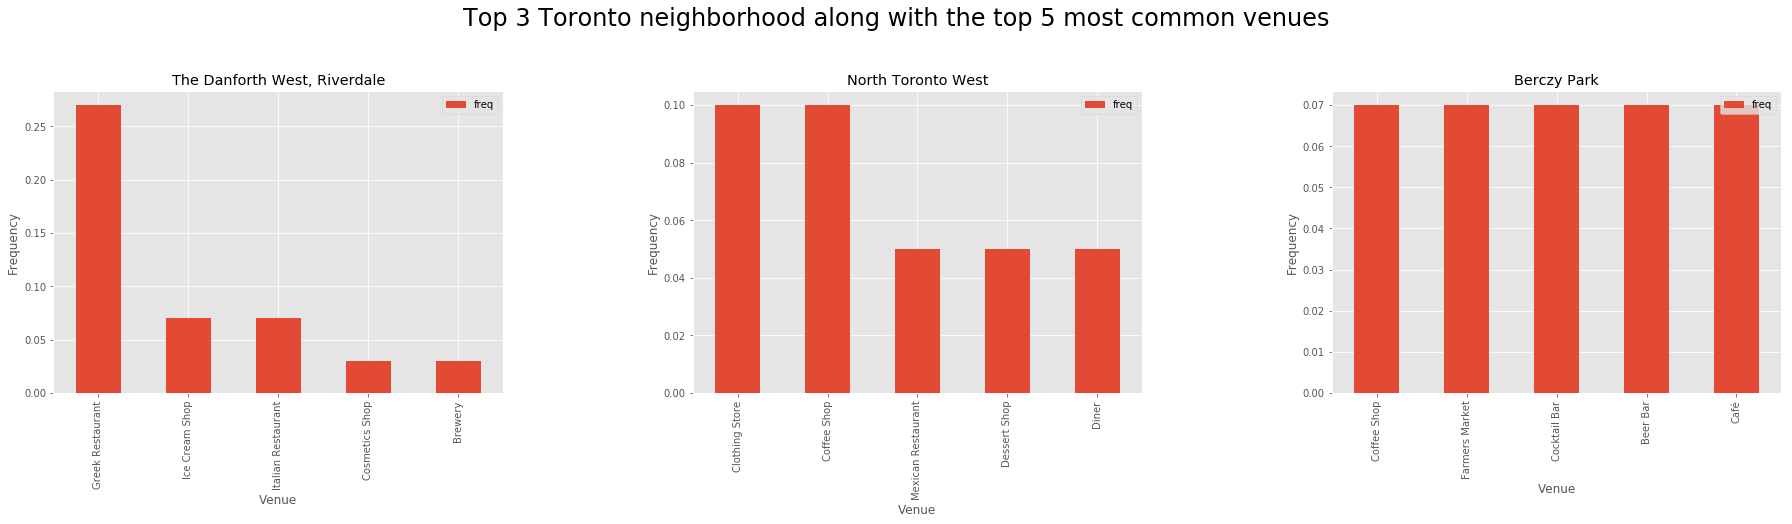

In [199]:

num_top_venues = 5


count = 0
fig, axes = plt.subplots(nrows=1, ncols=3)
#fig.suptitle('Top 3 neighborhood along with the top 5 most common venues')
fig.tight_layout()
for hood in toronto_grouped_top_3['Neighborhood']:
    #print("----"+hood+"----")
    temp = toronto_grouped_top_3[toronto_grouped_top_3['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:-1]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
    temp.set_index('venue', inplace=True)
    #print(temp)
    # step 2: plot data
    temp.plot(kind='bar', figsize=(30, 6),ax=axes[count])
    axes[count].set_xlabel('Venue') # add to x-label to the plot
    axes[count].set_ylabel('Frequency') # add y-label to the plot
    axes[count].set_title(hood) # add title to the plot
    count = count+1
fig.get_axes()[0].annotate('Top 3 Toronto neighborhood along with the top 5 most common venues', (0.5, 0.95), 
                            xycoords='figure fraction', ha='center', 
                            fontsize=24
                            )
plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.1)
print("")

Let's put that into a pandas dataframe

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [163]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
toronto_neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    toronto_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

toronto_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Steakhouse,Coffee Shop,Hotel,Pizza Place,Café,Asian Restaurant,Monument / Landmark,Noodle House,Opera House,Concert Hall
1,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Café,Seafood Restaurant,Farmers Market,Park,Bistro,Jazz Club,Basketball Stadium
2,"Brockton, Exhibition Place, Parkdale Village",Café,Coffee Shop,Breakfast Spot,Grocery Store,Stadium,Bar,Falafel Restaurant,Restaurant,Burrito Place,Caribbean Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Garden,Skate Park,Farmers Market,Fast Food Restaurant,Spa,Brewery,Restaurant,Burrito Place,Auto Workshop
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Service,Airport Terminal,Harbor / Marina,Bar,Coffee Shop,Plane,Sculpture Garden,Boutique,Boat or Ferry


---
**Analyze Each Neighborhood for New York**

However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [164]:
manhattan_data = df_newyork[df_newyork['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [166]:
# type your answer here
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
#save into a csv file in object storage in order to use in a future without load the data from Forsquare API
#project.save_data(data=manhattan_venues.to_csv(index=False),file_name='manhattan_venues.csv',overwrite=True)
print(manhattan_venues.shape)
manhattan_venues.head()

(1183, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


In [167]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


NNext, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [168]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Battery Park City,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.033333,0.0
1,Carnegie Hill,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,...,0.033333,0.0,0.0,0.0,0.0,0.0,0.033333,0.033333,0.000000,0.0
2,Central Harlem,0.0,0.0,0.0,0.1,0.066667,0.0,0.0,0.033333,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
3,Chelsea,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,...,0.033333,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
4,Chinatown,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [170]:
#clear the dataframe first for each execution
#manhattan_grouped_top_3 = manhattan_grouped_top_3.iloc[0:0]
manhattan_grouped_top_3 = manhattan_grouped.copy()
manhattan_grouped_top_3.set_index('Neighborhood', inplace=True)
manhattan_grouped_top_3.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Battery Park City,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.033333,0.0
Carnegie Hill,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,...,0.033333,0.0,0.0,0.0,0.0,0.0,0.033333,0.033333,0.000000,0.0
Central Harlem,0.0,0.0,0.0,0.1,0.066667,0.0,0.0,0.033333,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
Chelsea,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,...,0.033333,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
Chinatown,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0


Let's see top 3 neighborhood along with the top 5 most common venues for each neighborhood. So first we need to get first 3 neighborhood.

In [171]:
#sum mean for each Neighborhood
manhattan_grouped_top_3.loc[:,"Total"] = manhattan_grouped_top_3.sum(axis=1,skipna=True,numeric_only=True)
#order Neighborhood by total venue frecuency
manhattan_grouped_top_3 = manhattan_grouped_top_3.sort_values('Total', ascending=False).reset_index().head(3)
manhattan_grouped_top_3

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,...,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Total
0,East Harlem,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0
1,Battery Park City,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,1.0
2,Stuyvesant Town,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0


Plor 5 most common venues for each top 3 neighborhood.

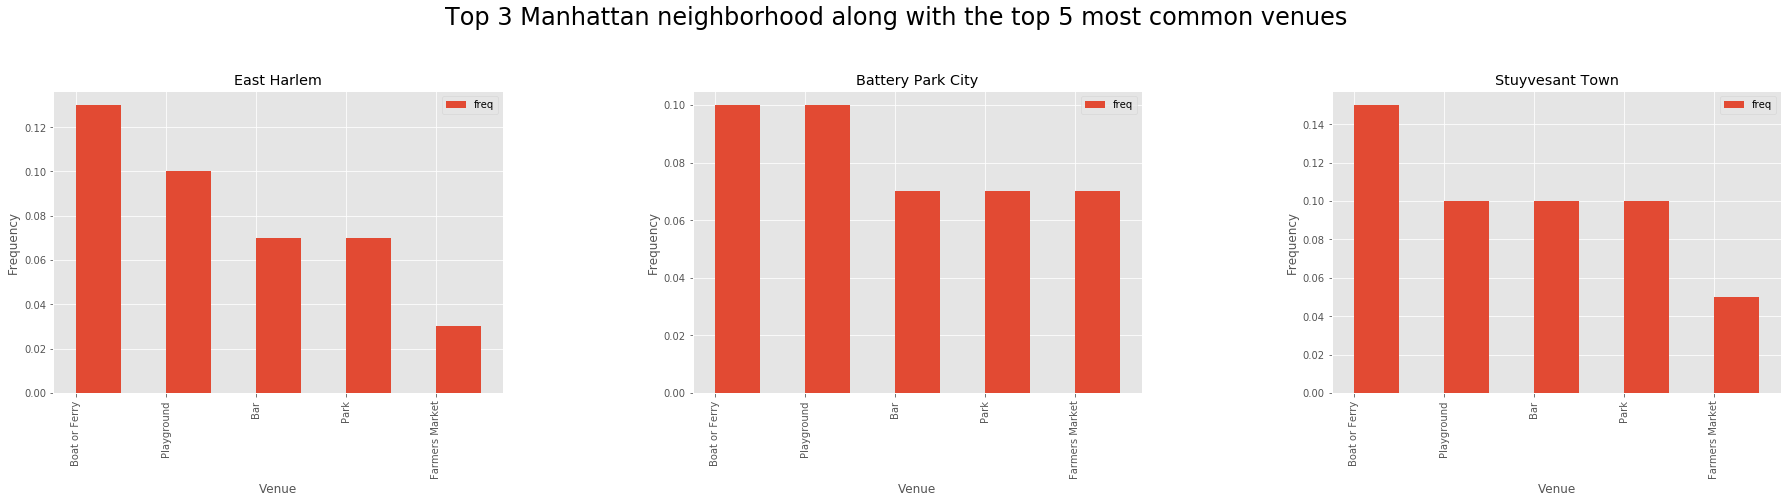

In [198]:
num_top_venues = 5

count = 0
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True)

fig.tight_layout()
for hood in manhattan_grouped_top_3['Neighborhood']:
    #print("----"+hood+"----")
    temp = manhattan_grouped_top_3[manhattan_grouped_top_3['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:-1]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
    temp.set_index('venue', inplace=True)
    #print(temp)
    # step 2: plot data
    temp.plot(kind='bar', figsize=(30, 6),position=0,ax=axes[count])
    axes[count].set_xlabel('Venue') # add to x-label to the plot
    axes[count].set_ylabel('Frequency') # add y-label to the plot
    axes[count].set_title(hood) # add title to the plot
    count = count+1
fig.get_axes()[0].annotate('Top 3 Manhattan neighborhood along with the top 5 most common venues', (0.5, 0.95), 
                            xycoords='figure fraction', ha='center', 
                            fontsize=24
                            )
plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.1)

print("")

Let's put that into a pandas dataframe

In [508]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
manhattan_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
manhattan_neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    manhattan_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

manhattan_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Memorial Site,Cupcake Shop,Department Store,Coffee Shop,Sandwich Place,Food Court,BBQ Joint,Performing Arts Venue,Scenic Lookout
1,Carnegie Hill,Italian Restaurant,Coffee Shop,Spa,Bookstore,Pizza Place,Gym,Gym / Fitness Center,French Restaurant,Restaurant,Bar
2,Central Harlem,African Restaurant,American Restaurant,French Restaurant,Chinese Restaurant,Cosmetics Shop,Caribbean Restaurant,Library,Boutique,Spa,Fried Chicken Joint
3,Chelsea,Hotel,Ice Cream Shop,Nightclub,Theater,Taco Place,Fish Market,Bar,Gift Shop,Beer Bar,Chinese Restaurant
4,Chinatown,Chinese Restaurant,Sandwich Place,Noodle House,Spa,Hotpot Restaurant,Korean Restaurant,Garden Center,Bike Shop,Bubble Tea Shop,English Restaurant


---
### 3.4 Cluster Neighborhoods

**Cluster Toronto Data**

Run k-means to cluster the neighborhood into 5 clusters.

In [506]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [509]:
# add clustering labels
df_toronto.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)
toronto_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Other Great Outdoors,Health Food Store,Trail,Pub,Cuban Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Dog Run,Discount Store
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,2,Greek Restaurant,Ice Cream Shop,Italian Restaurant,Cosmetics Shop,Brewery,Bubble Tea Shop,Restaurant,Pub,Pizza Place,Coffee Shop
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,2,Park,Ice Cream Shop,Brewery,Burger Joint,Fast Food Restaurant,Fish & Chips Shop,Burrito Place,Italian Restaurant,Pub,Steakhouse
3,M4M,East Toronto,Studio District,43.659526,-79.340923,2,Café,Coffee Shop,American Restaurant,Italian Restaurant,Bakery,Park,Cheese Shop,Sandwich Place,Bookstore,Seafood Restaurant
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1,Park,Swim School,Bus Line,College Gym,Deli / Bodega,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Dog Run,Discount Store


Finally, let's visualize the resulting clusters

In [526]:

toronto_merged = toronto_merged[pd.notnull(toronto_merged['Cluster Labels'])]

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Cluster New york Data**

Run k-means to cluster the neighborhood into 5 clusters.

In [527]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 0, 0, 0, 0, 0, 2, 4, 4, 4], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [528]:
# add clustering labels
manhattan_data.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)
manhattan_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(manhattan_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,1,Sandwich Place,Discount Store,Coffee Shop,Yoga Studio,Gym,Shopping Mall,Seafood Restaurant,Steakhouse,Supplement Shop,Donut Shop
1,Manhattan,Chinatown,40.715618,-73.994279,0,Chinese Restaurant,Sandwich Place,Noodle House,Spa,Hotpot Restaurant,Korean Restaurant,Garden Center,Bike Shop,Bubble Tea Shop,English Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,4,Wine Shop,Café,Park,Pizza Place,Lounge,Tapas Restaurant,Restaurant,Frozen Yogurt Shop,Latin American Restaurant,Liquor Store
3,Manhattan,Inwood,40.867684,-73.921210,4,Café,Mexican Restaurant,Wine Bar,Park,Deli / Bodega,Bakery,Restaurant,Yoga Studio,Frozen Yogurt Shop,Bistro
4,Manhattan,Hamilton Heights,40.823604,-73.949688,1,Coffee Shop,Yoga Studio,Café,Caribbean Restaurant,Cocktail Bar,Mexican Restaurant,Pub,Smoke Shop,Burger Joint,School


Finally, let's visualize the resulting clusters

In [529]:

manhattan_merged = manhattan_merged[pd.notnull(manhattan_merged['Cluster Labels'])]

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters